In [17]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.segmentation import clear_border
import numpy as np
%matplotlib inline

from skimage.measure import regionprops
import glob
import scipy.ndimage as scnd

In [18]:
def img_props(path, data=[]):
    
    img =  fits.open(path, ignore_missing_end = True )[0].data

    flt = threshold_otsu(img)
    otsu = img >= flt
    clr = clear_border(otsu)

    # label image regions
    label_image, nlabel = label(clr, return_num = True)
    borders = np.logical_xor(otsu, clr)
    label_image[borders] = -1

    props = regionprops(label_image)

    ratios = []
    areas = []

    for i in props:
        ratios.append(i.minor_axis_length/i.major_axis_length)
        areas.append(i.area)

    if len(props) > 1:
        pos = areas.index(max(areas))
    else:
        pos = 0
    
    properties = {'centroid': props[pos].centroid, 'major': props[pos].major_axis_length,
            'minor': props[pos].minor_axis_length, 'ratio': ratios[pos], 
            'angle': props[pos].orientation, 'area': props[pos].area, 'img': props[pos].image,
                 'clr': clr, 'label': label_image, 'orig': img}
    
    return properties


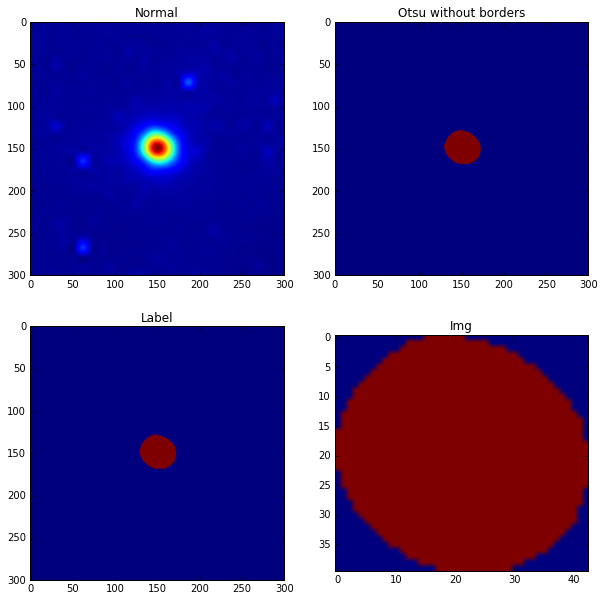

In [19]:
tprops = img_props('fb2/M13-dss2b.fits')


fig = plt.figure(figsize =(10,10))
ax = fig.add_subplot(2,2,1)
ax.set_title('Normal')
ax.imshow(tprops['orig'])

ax = fig.add_subplot(2,2,2)
ax.set_title('Otsu without borders')
ax.imshow(tprops['clr'])

ax = fig.add_subplot(2,2,3)
ax.set_title('Label')
ax.imshow(tprops['label'])

ax = fig.add_subplot(2,2,4)
ax.set_title('Img')
ax.imshow(tprops['img'])



plt.show()



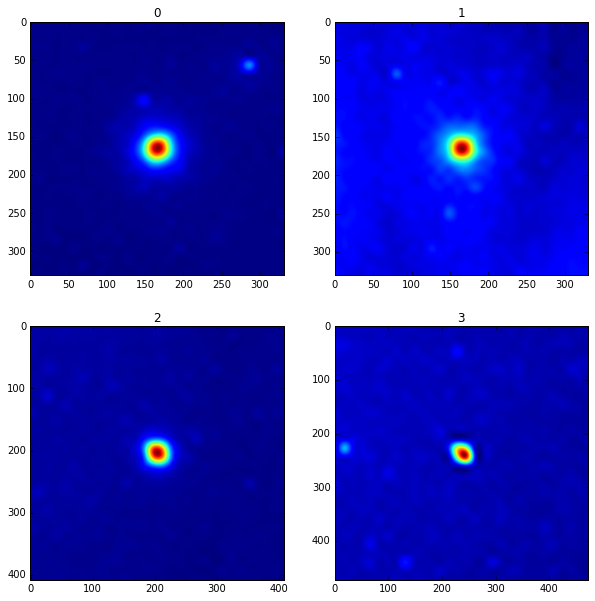

In [20]:
#SCALE
inputDir = 'test'

data = glob.glob(inputDir+'/*.fits')
arrays = []

for i in np.arange(len(data)):
    prop = img_props(data[i])
    scale = tprops['major']/prop['major']
    zoom = scnd.zoom(prop['orig'],scale)
    arrays.append(zoom)
    
fig2 = plt.figure(figsize =(10,10))
for i in np.arange(len(arrays)):
    ax = fig2.add_subplot(2,2,i+1)
    ax.set_title(str(i))
    ax.imshow(arrays[i])

plt.show()    

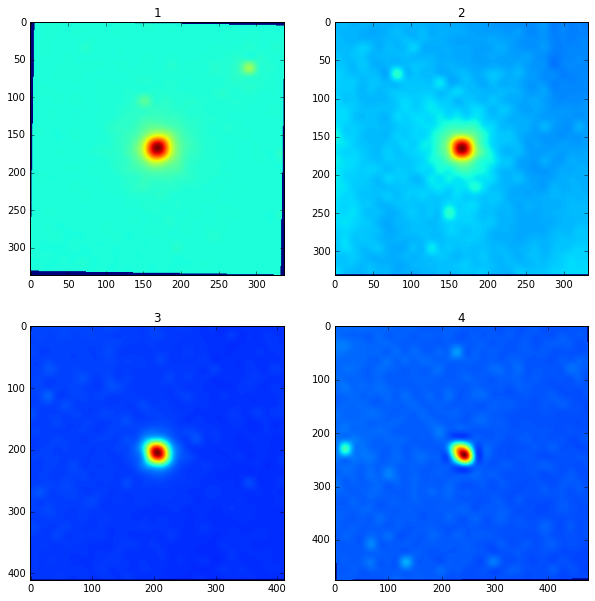

In [54]:
#ROTATE

ar2 = []
angles = []
for i in np.arange(len(data)):
    prop = img_props(data[i])
    angles.append(tprops['angle'] - prop['angle'])
    rotated = scnd.rotate(arrays[i], angles[-1], reshape = True)
    ar2.append(rotated)
    
fig2 = plt.figure(figsize =(10,10))
for i in np.arange(len(ar2)):
    ax = fig2.add_subplot(2,2,i+1)
    ax.set_title(str(i+1))
    ax.imshow(ar2[i])

plt.show()  


[[324, 324], [329, 329], [406, 406], [468, 468]]


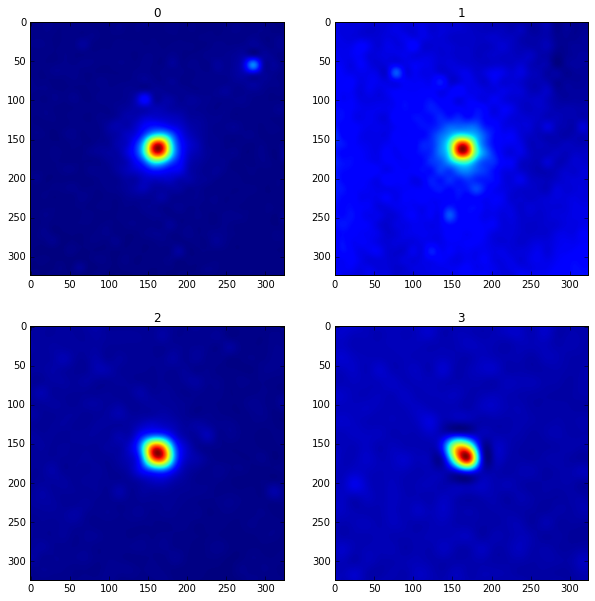

In [61]:
#CROP AND ALIGN
        
def limits(img,angle):
    if angle > 0:
        cx, cy = np.nonzero(np.array(img.T))
    else:
        cx, cy = np.nonzero(np.array(img))
    
    upper = (cx[0], cy[0])
    lower = (cx[-1], cy[-1])
    
    
    return upper,lower
    
    
ar3 = []
shapes = []

for i in np.arange(len(data)):
    
    upper, lower = limits(ar2[i],angles[i])
    
    crop = ar2[i][upper[1]:lower[1], upper[1]:lower[1]]

    shapes.append(list(crop.shape))
    
    ar3.append(crop)

print shapes
minShape = tuple(np.amin(shapes,axis=0))

for i in np.arange(len(ar3)):
    dxl = (ar3[i].shape[0]-minShape[0])/2
    dxr = (ar3[i].shape[0]+minShape[0])/2
    dyu = (ar3[i].shape[1]-minShape[1])/2
    dyd = (ar3[i].shape[1]+minShape[1])/2


    ar3[i] = ar3[i][dxl:dxr, dyu:dyd]
    
fig2 = plt.figure(figsize =(10,10))
for i in np.arange(len(ar3)):
    ax = fig2.add_subplot(2,2,i+1)
    ax.set_title(str(i))
    ax.imshow(ar3[i])

plt.show()    


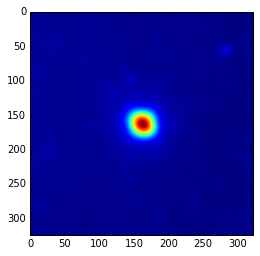

In [58]:
#Final_result
plt.imshow(np.mean(ar3, axis = 0))
plt.show()

In [ ]:
for i in np.arange(len(ar3)):
    hdu = fits.PrimaryHDU(ar3[i])
    hdulist = fits.HDUList([hdu])
    hdulist.writeto('p/new{}.fits'.format(i))
    